In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from scipy import stats
from scipy.optimize import minimize
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
data = pd.read_csv('../../notebooks/data/ex6_data.txt', sep='\t', header=None, names=['x'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


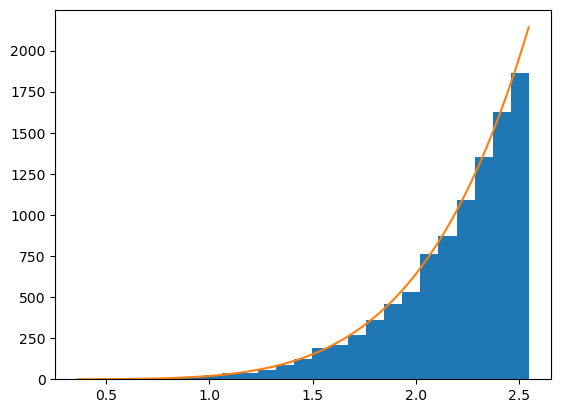

In [3]:
plt.hist(data.x, bins=25)

data.x.min(), data.x.max()
x_ = np.linspace(data.x.min(), data.x.max(), len(data.x))
plt.plot(x_, 20*x_**5,)

plt.show()

Thus the pdf for this sample has the  form $p(x) = Ae^{B}$

(0.3633268406037423, 2.546474057442313)

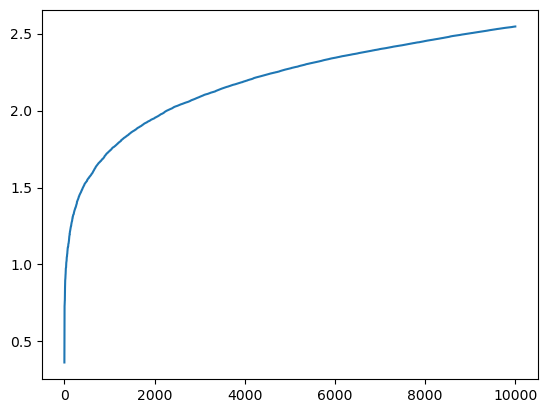

In [4]:
plt.plot(np.sort(data.x)) # plot sorted data
np.min(data.x), np.max(data.x)

(1e-05, 1.00001)

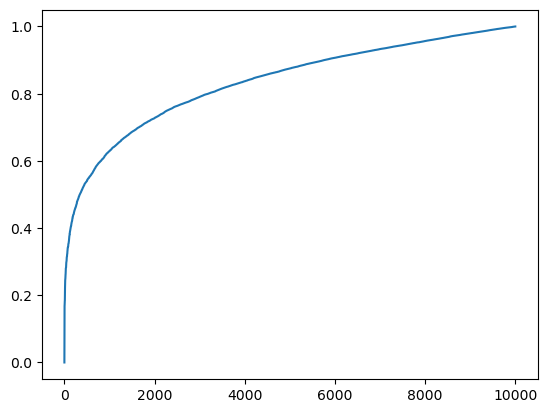

In [5]:
data["rescaled"] = (data.x - np.min(data.x)) / (np.max(data.x) - np.min(data.x)) + 1e-5 # rescale data to [0,1]
plt.plot(np.sort(data.rescaled))
np.min(data.rescaled), np.max(data.rescaled)

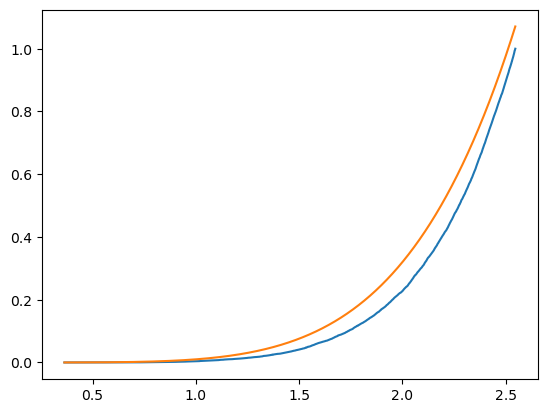

In [6]:
pdf = np.zeros_like(data.x) # compute empirical pdf as P(x) = (# of points < x) / (# of points)
for i, x in enumerate(np.sort(data.x)):
    pdf[i] = np.sum(data.x<x)
pdf = pdf/len(data.x)
plt.plot(np.sort(data.x), pdf)
plt.plot(x_, 1/100*x_**5,)
#plt.yscale('log')
#plt.xscale('log')

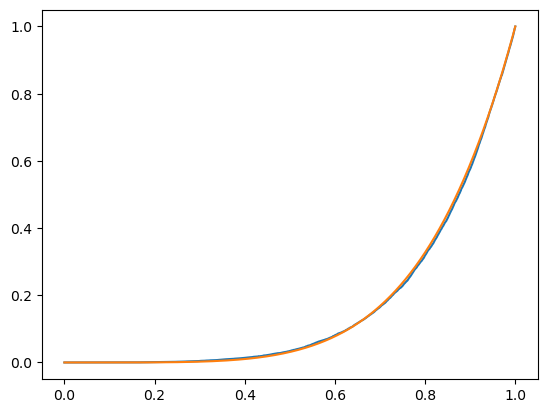

In [7]:
def power_law_pdf(x, index, norm): # power law pdf
    return norm*x**index

def make_pdf(data): #estimate pdf as p(x) = (# of points < x) / (# of points)
    data = np.sort(data)
    pdf = np.zeros_like(data)
    for i, x_ in enumerate(data):
        pdf[i] = np.sum(data<x_)/len(data)
    return pdf

sorted = np.sort(data.rescaled)

plt.plot(sorted, make_pdf(sorted))
plt.plot(sorted, power_law_pdf(sorted, 5, 1))

### Bye eye the real (rescaled) pdf seems to be $$ p(x) = x^5 $$

In [8]:
def log_likelihood(params, x): # log likelihood function
    nu, index = params
    model = (np.sort(x))**(index)
    #model = make_pdf(model)
    #nu = nu*index
    logL = -nu + np.sum(np.log(nu*model))
    return -logL

# attempt to minimize with scipy

minimize(log_likelihood, x0=[0.5,4], args=(np.sort(data.rescaled)), 
         method='SLSQP', 
         bounds=[(1e-5, 1e2), (0, 20)], 
         tol=1e-8,)

     fun: -45951.70185988092
     jac: array([ -99.      , 2011.578125])
 message: 'Optimization terminated successfully'
    nfev: 27
     nit: 12
    njev: 8
  status: 0
 success: True
       x: array([100.,   0.])

In [9]:
from iminuit import Minuit # attempt to minimize with iminuit

def log_likelihood_(nu, index):
    model = (np.sort(data.rescaled))**(index)
    #model = make_pdf(model)
    logL = -nu + np.sum(np.log(nu*model)) 
    return -logL

m = Minuit(log_likelihood_ ,nu = 1, index=8,)
m.limits["index"] = (1, 10)
m.limits["nu"] = (0,3)
#m.limits["norm"] = (1e-3,10)

m.migrad()
m.hesse()
#m.minos()
#m.interactive()


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -8972                      │              Nfcn = 68               │
│ EDM = 4.14e-13 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ nu    │  3.0000   │  0.0003   │            │            │    0    │    3    │       │
│ 1 │ index │  1.0000   │  0.0005   │            │            │    1    │   10    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       nu    index │
├───────┼───────────────────┤
│    nu │ 7.79e-20        0 │
│ index │        0 1.95e-19 │
└───────┴───────────────────┘

# ????